In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

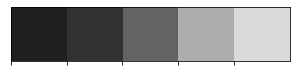

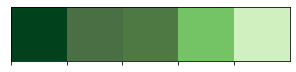

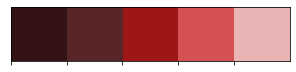

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
X_train = []
y_train = []
image_size = 128
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:01<00:00, 69.50it/s]


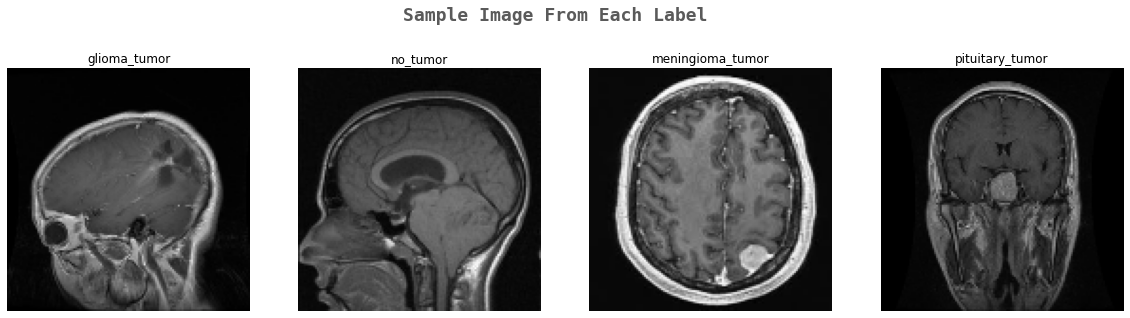

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train.shape

(3264, 128, 128, 3)

In [8]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(3264, 128, 128, 3)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [11]:
from tensorflow.keras.applications import ResNet152V2
resnet = ResNet152V2(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))


234553344/234545216 [==============================] - 2s 0us/step


**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [12]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [15]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet152v1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [16]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =25, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/25
83/83 [==============================] - 38s 240ms/step - loss: 0.9956 - accuracy: 0.5985 - val_loss: 621.2119 - val_accuracy: 0.1531

Epoch 00001: val_accuracy improved from -inf to 0.15306, saving model to resnet152v1.h5
Epoch 2/25
83/83 [==============================] - 15s 182ms/step - loss: 0.4367 - accuracy: 0.8470 - val_loss: 7.4573 - val_accuracy: 0.2789

Epoch 00002: val_accuracy improved from 0.15306 to 0.27891, saving model to resnet152v1.h5
Epoch 3/25
83/83 [==============================] - 15s 182ms/step - loss: 0.3825 - accuracy: 0.8743 - val_loss: 0.7860 - val_accuracy: 0.7687

Epoch 00003: val_accuracy improved from 0.27891 to 0.76871, saving model to resnet152v1.h5
Epoch 4/25
83/83 [==============================] - 15s 181ms/step - loss: 0.2692 - accuracy: 0.9075 - val_loss: 0.8268 - val_accuracy: 0.6463

Epoch 00004: val_accuracy did not improve from 0.76871
Epoch 5/25
83/83 [==============================] - 15s 182ms/step - loss: 0.2040 - accuracy: 0.9

In [17]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [18]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        93
           1       0.92      0.86      0.89        51
           2       0.94      0.92      0.93        96
           3       0.93      1.00      0.96        87

    accuracy                           0.93       327
   macro avg       0.93      0.92      0.92       327
weighted avg       0.93      0.93      0.93       327



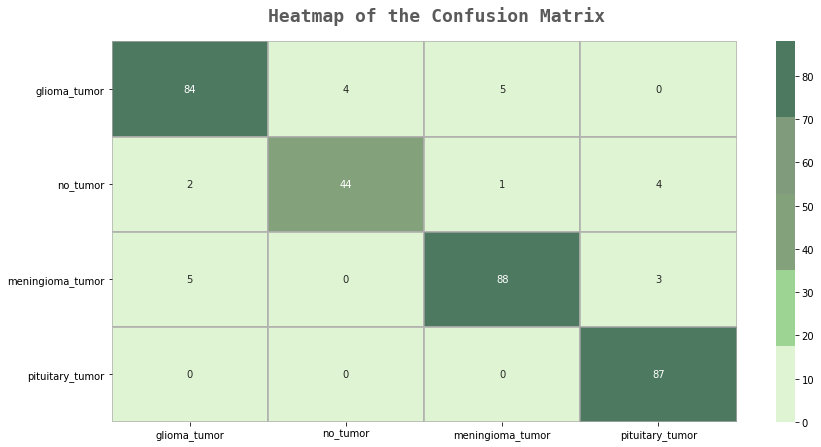

In [19]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()